In [1]:
import os
os.chdir("/Users/karol/Desktop/Antwerp/ai_project")
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from recommenders import recommender_softmax, recommender_two_towers, recommender_two_towers_embedded, recommender_two_towers_final, recommender_two_towers_customer
from data_reader import load_data, load_data_mf, matrix_representation, load_customers_articles, customers_diversification, articles_diversification
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.sparse import csr_matrix
from tqdm import tqdm
import pickle

In [2]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 
transactions = pd.read_csv("data/preprocessed/transactions.csv")
articles = pd.read_csv("data/preprocessed/articles.csv") 

# Developed Models

### MLP models

In [3]:
MLP1 = torch.load("AI_project/RQ1/models/MLP1.pt")
MLP2 = torch.load("AI_project/RQ1/models/MLP2.pt")
train_dataloader_MLP, val_dataloader_MLP = load_data(transactions, train_test=True, batch_size=1000)

last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]

recall_MLP1_list = []
precision_MLP1_list = []

recall_MLP2_list = []
precision_MLP2_list = []

for k in tqdm(np.arange(5,35,5)):
    _, recall_MLP1, precisionMLP1 = recommender_softmax(MLP1, val_dataloader_MLP, articles_recently_sold, evaluate=True, top_k=k)
    _, recall_MLP2, precisionMLP2 = recommender_softmax(MLP2, val_dataloader_MLP, articles_recently_sold, evaluate=True, top_k=k)
    
    recall_MLP1_list.append(recall_MLP1.item())
    recall_MLP2_list.append(recall_MLP2.item())
    precision_MLP1_list.append(precisionMLP1.item())
    precision_MLP2_list.append(precisionMLP2.item())

 50%|█████     | 3/6 [09:41<09:46, 195.48s/it]/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/recommenders.py:28: UserWarning: torch.topk support for k>16 by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Shape.mm:71.)
  _, top_k_indices = torch.topk(results, k=top_k, dim=1)
100%|██████████| 6/6 [19:50<00:00, 198.44s/it]


In [4]:
with open('AI_project/RQ1/evaluation/recall/recall_MLP1.pkl', 'wb') as f:
    pickle.dump(recall_MLP1_list, f)

with open('AI_project/RQ1/evaluation/recall/recall_MLP2.pkl', 'wb') as f:
    pickle.dump(recall_MLP2_list, f)

with open('AI_project/RQ1/evaluation/precision/precision_MLP1.pkl', 'wb') as f:
    pickle.dump(precision_MLP1_list, f)

with open('AI_project/RQ1/evaluation/precision/precision_MLP2.pkl', 'wb') as f:
    pickle.dump(precision_MLP2_list, f)

In [ ]:
plt.plot(np.arange(5,35,5),precision_MLP1_list,  label="MLP1")
plt.plot(np.arange(5,35,5), precision_MLP2_list,  label="MLP2")
# plt.plot(np.arange(5,30,5),precision_random_list, label="Random")
plt.title("Precision")
plt.legend()
plt.xlabel("k")
plt.ylabel("precision")
plt.show()

### TwoTower Models

In [3]:
# read data
transactions = pd.read_csv("data/preprocessed/transactions.csv") 
articles = pd.read_csv("data/preprocessed/articles.csv") 
customers = pd.read_csv("data/preprocessed/customers.csv") 

# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

article_enc = OneHotEncoder(sparse_output=True)
articles = article_enc.fit_transform(articles)

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency"]
customers_cont = ["age"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))

In [4]:
TwoTowerBasic = torch.load("AI_project/RQ1/models/TwoTower1.pt")
TwoTowerDeep = torch.load("AI_project/RQ1/models/TwoTowerFinal.pt")
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")

train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)

last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]

recall_Basic_list = []
precision_Basic_list = []
recall_Deep_list = []
precision_Deep_list = []

for k in tqdm(np.arange(5,35,5)):
    _, recall_Basic, precision_Basic = recommender_two_towers(TwoTowerBasic, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=k)
    _, recall_Deep, precision_Deep =  recommender_two_towers_final(TwoTowerDeep, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=k)
    
    recall_Basic_list.append(recall_Basic)
    recall_Deep_list.append(recall_Deep)
    precision_Basic_list.append(precision_Basic)
    precision_Deep_list.append(precision_Deep)

  0%|          | 0/6 [00:00<?, ?it/s]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:09<00:00, 146.13it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 244.99it/s]


Get recommendations...


100%|██████████| 137/137 [00:32<00:00,  4.20it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:15<00:00, 90.83it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 230.78it/s]


Get recommendations...


 17%|█▋        | 1/6 [04:53<24:25, 293.05s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 234.55it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 249.30it/s]


Get recommendations...


100%|██████████| 137/137 [00:32<00:00,  4.26it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 201.72it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 239.05it/s]


Get recommendations...


 33%|███▎      | 2/6 [09:42<19:23, 290.75s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 231.00it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 239.71it/s]


Get recommendations...


100%|██████████| 137/137 [00:31<00:00,  4.35it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 200.41it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 242.91it/s]


Get recommendations...


 50%|█████     | 3/6 [14:46<14:50, 296.84s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 229.97it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 242.22it/s]


Get recommendations...


100%|██████████| 137/137 [00:31<00:00,  4.38it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 205.51it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 242.47it/s]


Get recommendations...


 67%|██████▋   | 4/6 [19:42<09:53, 296.73s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 220.07it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 235.66it/s]


Get recommendations...


100%|██████████| 137/137 [00:33<00:00,  4.06it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 205.02it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 239.50it/s]


Get recommendations...


 83%|████████▎ | 5/6 [24:46<04:59, 299.32s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 235.16it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 244.17it/s]


Get recommendations...


100%|██████████| 137/137 [00:31<00:00,  4.29it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 207.20it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 240.45it/s]


Get recommendations...


100%|██████████| 6/6 [29:49<00:00, 298.24s/it]


In [5]:
with open('AI_project/RQ1/evaluation/recall/recall_Basic.pkl', 'wb') as f:
    pickle.dump(recall_Basic_list, f)

with open('AI_project/RQ1/evaluation/recall/recall_Deep.pkl', 'wb') as f:
    pickle.dump(recall_Deep_list, f)

with open('AI_project/RQ1/evaluation/precision/precision_Basic.pkl', 'wb') as f:
    pickle.dump(precision_Basic_list, f)

with open('AI_project/RQ1/evaluation/precision/precision_Deep.pkl', 'wb') as f:
    pickle.dump(precision_Deep_list, f)

In [3]:
# read article and customer data
articles = pd.read_csv("data/preprocessed/articles.csv") 
customers = pd.read_csv("data/preprocessed/customers.csv") 

# set indices
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency"]
customers_cont = ["age"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))
articles = csr_matrix(articles)

# load transaction
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")
# dataloader
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)

In [4]:
TwoTowerEmbeddings = torch.load("AI_project/RQ1/models/TwoTowerEmbedded.pt")

matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)

last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]

recall_Embeddings_list = []
precision_Embeddings_list = []


for k in tqdm(np.arange(5,35,5)):
    _, recall_Embeddings, precision_Embeddings =  recommender_two_towers_embedded(TwoTowerEmbeddings, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=k)
    recall_Embeddings_list.append(recall_Embeddings)
    precision_Embeddings_list.append(precision_Embeddings)

  0%|          | 0/6 [00:00<?, ?it/s]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 252.61it/s]


Generate Articles Embeddings...


/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/model.py:81: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  embedding_layer(x[:,i].T)
100%|██████████| 1056/1056 [00:04<00:00, 245.97it/s]


Get recommendations...


 17%|█▋        | 1/6 [02:26<12:12, 146.55s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 269.85it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 256.32it/s]


Get recommendations...


 33%|███▎      | 2/6 [04:52<09:43, 145.95s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 270.50it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:03<00:00, 272.27it/s]


Get recommendations...


 50%|█████     | 3/6 [07:20<07:21, 147.17s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:04<00:00, 282.55it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 255.59it/s]


Get recommendations...


 67%|██████▋   | 4/6 [09:54<04:59, 149.62s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:04<00:00, 285.82it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:03<00:00, 272.73it/s]


Get recommendations...


 83%|████████▎ | 5/6 [12:28<02:31, 151.40s/it]

Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:05<00:00, 270.00it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:03<00:00, 275.90it/s]


Get recommendations...


100%|██████████| 6/6 [15:08<00:00, 151.41s/it]


In [5]:
with open('AI_project/RQ1/evaluation/recall/recall_Embeddings.pkl', 'wb') as f:
    pickle.dump(recall_Embeddings_list, f)

with open('AI_project/RQ1/evaluation/precision/precision_Embeddings.pkl', 'wb') as f:
    pickle.dump(precision_Embeddings_list, f)

# Customer and Articles diversification

In [8]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 
transactions = pd.read_csv("data/preprocessed/transactions.csv")
articles = pd.read_csv("data/preprocessed/articles.csv") 
customers = customers_diversification(customers, transactions, articles)


In [10]:
# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

article_enc = OneHotEncoder(sparse_output=True)
articles = article_enc.fit_transform(articles)

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency", "favourite_color", "preferred_garment"]
customers_cont = ["age","first_channel", "second_channel", "avg_price", "amount_purchases","manswear","ladieswear", "kids"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))
# load transaction
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")
# dataloader
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)

In [11]:
TwoTowerCustomer = torch.load("AI_project/RQ1/models/TwoTowerCustomer.pt")
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]

recall_Cust_list = []
precision_Cust_list = []

for k in np.arange(5,35,5):
    _, recall_customer, precision_customer = recommender_two_towers_customer(TwoTowerCustomer, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=k)
    recall_Cust_list.append(recall_customer)
    precision_Cust_list.append(precision_customer)


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:10<00:00, 125.98it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:05<00:00, 195.27it/s]


Get recommendations...


100%|██████████| 137/137 [00:39<00:00,  3.47it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 200.70it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:05<00:00, 202.55it/s]


Get recommendations...


100%|██████████| 137/137 [00:36<00:00,  3.72it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 203.95it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 222.39it/s]


Get recommendations...


100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:07<00:00, 183.70it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 213.01it/s]


Get recommendations...


100%|██████████| 137/137 [00:37<00:00,  3.67it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 211.16it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 242.48it/s]


Get recommendations...


100%|██████████| 137/137 [00:32<00:00,  4.24it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 210.04it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 244.22it/s]


Get recommendations...


100%|██████████| 137/137 [00:32<00:00,  4.19it/s]


In [12]:
with open('AI_project/RQ1/evaluation/recall/recall_Cust.pkl', 'wb') as f:
    pickle.dump(recall_Cust_list, f)

with open('AI_project/RQ1/evaluation/precision/precision_Cust.pkl', 'wb') as f:
    pickle.dump(precision_Cust_list, f)

In [6]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 
transactions = pd.read_csv("data/preprocessed/transactions.csv")
articles = pd.read_csv("data/preprocessed/articles.csv") 
articles = articles_diversification(articles, transactions, customers)

AGE GROUP DISTRIBUTION

age_group
adult_preferences         492701
young_preference          357169
middle_aged_preference    339444
senior_preference         182666
Name: count, dtype: int64


/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/data_reader.py:609: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = t.groupby(["article_id", "age_group"])["customer_id"].count()


In [7]:
# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

articles_categorical = ["product_type_name","graphical_appearance_name",
                        "perceived_colour_master_name","department_name",
                        "index_name","section_name","garment_group_name"]

articles_cont = ['winter_sale', 'spring_sale','summer_sale', 'autumn_sale',
                'avg_price','young_preference', 'adult_preferences', 
                'middle_aged_preference','senior_preference', 
                'sales_channel_2', 'sales_channel_1']

min_max_cols = ['rank_3_2020', 'rank_4_2020']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), articles_categorical),
        ('cont', 'passthrough', articles_cont),
        ("min_max", MinMaxScaler(), min_max_cols)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)

articles = csr_matrix(preprocessor.fit_transform(articles))

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency"]
customers_cont = ["age"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))
# load transaction
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")
# dataloader
train_dataloader, val_dataloader, test_customers = load_data_mf(transactions_negatives, batch_size=1000)

In [9]:
TwoTower = torch.load("AI_project/RQ1/models/TwoTowerArticles.pt")
matrix_full = matrix_representation(transactions, train_test=False)
targets = matrix_full[test_customers]
targets[targets>1] = 1
# dataloader
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=test_customers, batch_size=100)
# get restrictions
last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = [last_sold[last_sold > '2020-08-22'].index.tolist()]

recall_Art_list = []
precision_Art_list = []

for k in np.arange(5,35,5):
    _, recall_art, precision_art = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets, articles_recently_sold, evaluate=True, top_k=k)
    recall_Art_list.append(recall_art)
    precision_Art_list.append(precision_art)


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:10<00:00, 136.22it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:05<00:00, 204.53it/s]


Get recommendations...


100%|██████████| 137/137 [00:35<00:00,  3.88it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 206.82it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 238.04it/s]


Get recommendations...


100%|██████████| 137/137 [00:33<00:00,  4.04it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:08<00:00, 168.85it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:05<00:00, 194.55it/s]


Get recommendations...


100%|██████████| 137/137 [00:37<00:00,  3.63it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:09<00:00, 139.39it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 234.17it/s]


Get recommendations...


100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 211.59it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 243.10it/s]


Get recommendations...


100%|██████████| 137/137 [00:33<00:00,  4.07it/s]


Generate Customer Embeddings...


100%|██████████| 1363/1363 [00:06<00:00, 211.36it/s]


Generate Articles Embeddings...


100%|██████████| 1056/1056 [00:04<00:00, 243.41it/s]


Get recommendations...


100%|██████████| 137/137 [00:32<00:00,  4.20it/s]


In [10]:
with open('AI_project/RQ1/evaluation/recall/recall_Art.pkl', 'wb') as f:
    pickle.dump(recall_Art_list, f)

with open('AI_project/RQ1/evaluation/precision/precision_Art.pkl', 'wb') as f:
    pickle.dump(precision_Art_list, f)

# Plots

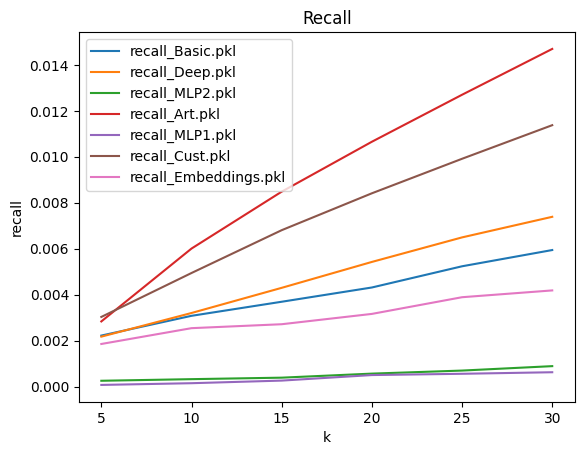

In [11]:
# Directory containing the pickle files
folder_path = 'AI_project/RQ1/evaluation/recall'

# Initialize an empty list to store loaded lists
all_lists = []

# Iterate through the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if filename.endswith('.pkl'):
        # Load the list from the pickle file and append it to all_lists
        with open(file_path, 'rb') as f:
            loaded_list = pickle.load(f)
            all_lists.append(loaded_list)
            plt.plot(np.arange(5,35,5),loaded_list, label=filename)
plt.title("Recall")
plt.legend()
plt.xlabel("k")
plt.ylabel("recall")
plt.show()

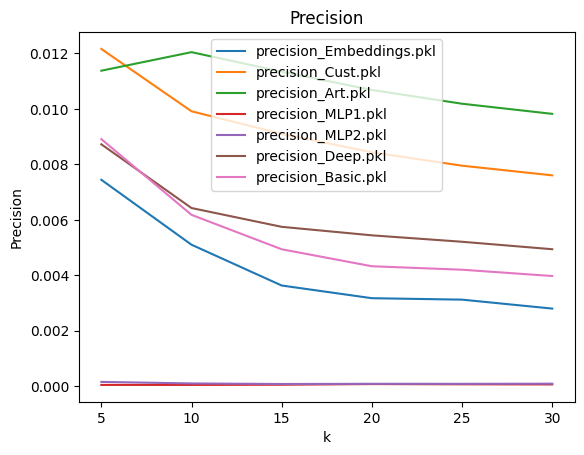

In [13]:
# Directory containing the pickle files
folder_path = 'AI_project/RQ1/evaluation/precision'

# Initialize an empty list to store loaded lists
all_lists = []

# Iterate through the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if filename.endswith('.pkl'):
        # Load the list from the pickle file and append it to all_lists
        with open(file_path, 'rb') as f:
            loaded_list = pickle.load(f)
            all_lists.append(loaded_list)
            plt.plot(np.arange(5,35,5),loaded_list, label=filename)
plt.title("Precision")
plt.legend()
plt.xlabel("k")
plt.ylabel("Precision")
plt.show()